1)  If a decision tree is under-fitting the training dataset, is it a good idea to try scaling the input features?
    No. Decision trees do not care if the data is scaled or not. Scaling the data would be a waste of time.

2) If a decision tree is over-fitting the training dataset, is it a good idea to try decreasing max depth?
    Yes, this is a good decision in this situation. This help regularize your model.
    
3) Why would you use a random forest instead of a decision tree? 
    When you have a large dataset, which may help an overfitting problem with decision trees.

4) Which of the folowing are true about bagging trees? A and C

5) see .pdf attachment


In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score

from sklearn.ensemble import RandomForestClassifier

## define bucket in which you are trying to reach
s3 = boto3.resource('s3')
bucket_name = 'daltondencklau-data445-bucket'
bucket = s3.Bucket(bucket_name)

## define csv file to read in the bucket
file_key= 'framingham.csv'

## syntax to allow us to read the file
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## reading the data file
heart = pd.read_csv(file_content_stream)
heart.head()

Matplotlib is building the font cache; this may take a moment.


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [2]:
heart = heart.dropna()

In [3]:
## defining the input and target variables
X = heart.drop(columns = ['TenYearCHD'], axis = 1)
Y = heart['TenYearCHD']

In [4]:
## creating loop: feature importance
for i in range (0,100):
    
    print(i)
    
    ## splitting the data in 80% and 20% testing, stratifying y
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## building random forest model w 500 trees
    rf_md = RandomForestClassifier(n_estimators = 500).fit(X_train, Y_train)
    
    ## extracting the important features
    importances = pd.DataFrame({'Feature': X_train.columns, 'Importances': rf_md.feature_importances_})
    
    ## printing important features in order of importance
    importances = importances.sort_values(by = 'Importances', ascending = False)
    importances

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [5]:
importances.head()

,Feature,Importances
10,sysBP,0.136312
1,age,0.128548
12,BMI,0.125081
9,totChol,0.121995
14,glucose,0.119592


In [6]:
## using the top 5 variables as new input variables
X_rf = heart[['sysBP', 'BMI', 'age', 'totChol', 'glucose']]
Y_rf = heart['TenYearCHD']

In [7]:
## creating loop to predict TenYearCHD

## creating a list to store results
md1_results = list()
md2_results = list()
md3_results = list()

for i in range(0,100):
    
    print(i)
    
    ## splitting the data into 80% training and 20% testing
    X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(X_rf, Y_rf, test_size = 0.2, stratify = Y)
    
    ## building random forest classifier models to consider
    md1 = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train_rf, Y_train_rf)
    md2 = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(X_train_rf, Y_train_rf)
    md3 = RandomForestClassifier(n_estimators = 500, max_depth = 7).fit(X_train_rf, Y_train_rf)
    
    ## predicting on the testing data set
    md1_preds = md1.predict_proba(X_test_rf)[:, 1]
    md2_preds = md2.predict_proba(X_test_rf)[:, 1]
    md3_preds = md3.predict_proba(X_test_rf)[:, 1]
    
    ## changing likelihoods to labes using a 10% cuttoff value
    md1_labels = np.where(md1_preds < 0.1, 0, 1)
    md2_labels = np.where(md2_preds < 0.1, 0, 1)
    md3_labels = np.where(md3_preds < 0.1, 0, 1)
    
    ## calculating the recall score
    md1_recall = recall_score(Y_test_rf, md1_labels)
    md2_recall = recall_score(Y_test_rf, md2_labels)
    md3_recall = recall_score(Y_test_rf, md3_labels)
    
    ## appending the results to a list
    md1_results.append(md1_recall)
    md2_results.append(md2_recall)
    md3_results.append(md3_recall)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [8]:
## printing the recall value
print('The average Recall score for Model 1 is', np.mean(md1_recall))
print('The average Recall score for Model 2 is', np.mean(md2_recall))
print('The average Recall score for Model 3 is', np.mean(md3_recall))

The average Recall score for Model 1 is 0.8660714285714286
The average Recall score for Model 2 is 0.8392857142857143
The average Recall score for Model 3 is 0.8214285714285714


In [9]:
md1_results>md2_results>md3_results

True

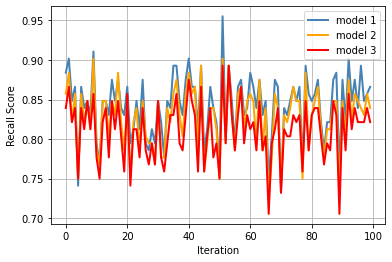

In [10]:
## creating a visualization showing the recall for each model at all iterations
plt.plot(md1_results , linewidth = 2, color = 'steelblue')
plt.plot(md2_results , linewidth = 2, color = 'orange')
plt.plot(md3_results , linewidth = 2, color = 'red')
plt.xlabel('Iteration')
plt.ylabel('Recall Score')
plt.legend(loc = 'upper right', labels = ['model 1', 'model 2', 'model 3'])
plt.grid()
plt.grid
plt.show;

Based on the average recall scores and the visualization above, I would chose Model 1 to predict patient's risk of coronary heart disease because it has the highest average recall score.